### Load modules

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob
import time

#### Define data paths

In [2]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\imgB\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\9_week\\data\\mskB\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.9

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


90


#### Make dataset

In [3]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


#### Make dataloaders

In [4]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [ ]:
print(len(test_loader.dataset))

In [ ]:
#test print
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[0][1][0],cmap ='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[0][0][0],cmap ='gray')
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

### Networks

#### Set GPU device

In [5]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Functions for the network

In [6]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [8]:
def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.xavier_normal_(m.weight.data, gain = 1.0) 
        #nn.init.kaiming_uniform_(m.weight.data, a=math.sqrt(5))
        #nn.init.xavier_normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias, 0)


#### Image-to-image network 

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
      
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))

        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
 
        x = self.out(x)
    
        return x
  

In [9]:
import math

### Define model and train

In [10]:
model = UNet()
model = model.to(device)
model.apply(weights_init)
# print(model)

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 

In [ ]:
test_im = torch.rand(1,1,256,256)
test_im = test_im.to(device)
outputs = model(test_im)

In [ ]:
## this definition was esperimentally used as processing for mask before prediction
def Apply_filter(masks):
    m_f=[]
    for i,msk in enumerate(masks):
        klen = 10
        kernel = np.ones(klen)
        k = np.ones([1,20,20])
        msk = gaussian_filter(msk,10) 
        m_f.append(msk)
    return torch.from_numpy(m_f)

#### Training

In [11]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

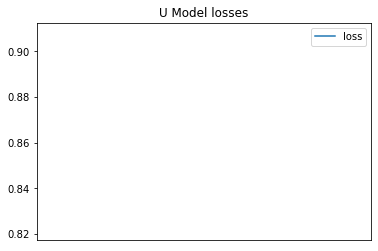

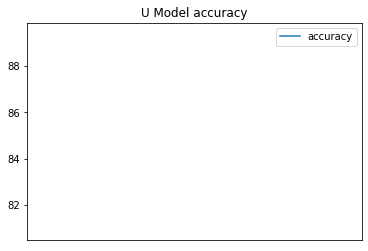

Epoch [1/1000], Step [0/27], Loss: 0.864868, Accuracy:85.16438802083333
Epoch [2/1000], Step [0/27], Loss: 0.270859, Accuracy:84.72035725911458
Epoch [3/1000], Step [0/27], Loss: 0.177323, Accuracy:88.543701171875
Epoch [4/1000], Step [0/27], Loss: 0.164845, Accuracy:90.59295654296875
Epoch [5/1000], Step [0/27], Loss: 0.182763, Accuracy:82.99001057942708
Epoch [6/1000], Step [0/27], Loss: 0.146645, Accuracy:86.48427327473958
Epoch [7/1000], Step [0/27], Loss: 0.176230, Accuracy:82.0037841796875
Epoch [8/1000], Step [0/27], Loss: 0.141880, Accuracy:88.4307861328125
Epoch [9/1000], Step [0/27], Loss: 0.140045, Accuracy:86.25437418619792
Epoch [10/1000], Step [0/27], Loss: 0.130985, Accuracy:86.94000244140625
Epoch [11/1000], Step [0/27], Loss: 0.140108, Accuracy:87.32452392578125
Epoch [12/1000], Step [0/27], Loss: 0.146308, Accuracy:87.11954752604167
Epoch [13/1000], Step [0/27], Loss: 0.148931, Accuracy:83.62375895182292
Epoch [14/1000], Step [0/27], Loss: 0.125718, Accuracy:86.990865

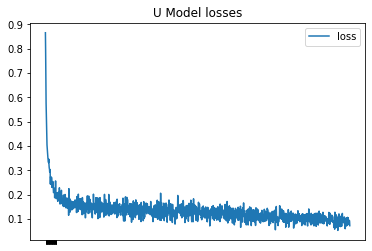

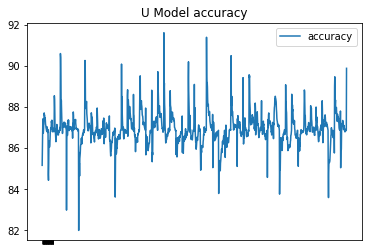

Epoch [51/1000], Step [0/27], Loss: 0.072389, Accuracy:89.87579345703125
Epoch [52/1000], Step [0/27], Loss: 0.072084, Accuracy:88.5955810546875
Epoch [53/1000], Step [0/27], Loss: 0.095412, Accuracy:84.41416422526042
Epoch [54/1000], Step [0/27], Loss: 0.066628, Accuracy:91.76228841145833
Epoch [55/1000], Step [0/27], Loss: 0.085837, Accuracy:86.54734293619792
Epoch [56/1000], Step [0/27], Loss: 0.073478, Accuracy:89.58282470703125
Epoch [57/1000], Step [0/27], Loss: 0.084433, Accuracy:85.784912109375
Epoch [58/1000], Step [0/27], Loss: 0.078279, Accuracy:88.26141357421875
Epoch [59/1000], Step [0/27], Loss: 0.101229, Accuracy:83.68886311848958
Epoch [60/1000], Step [0/27], Loss: 0.057073, Accuracy:89.72269694010417
Epoch [61/1000], Step [0/27], Loss: 0.064921, Accuracy:89.01265462239583
Epoch [62/1000], Step [0/27], Loss: 0.083157, Accuracy:85.22186279296875
Epoch [63/1000], Step [0/27], Loss: 0.082093, Accuracy:85.589599609375
Epoch [64/1000], Step [0/27], Loss: 0.089110, Accuracy:8

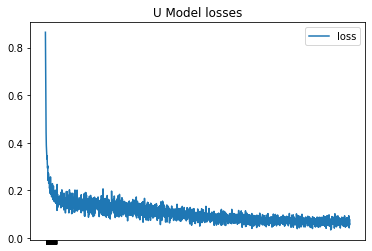

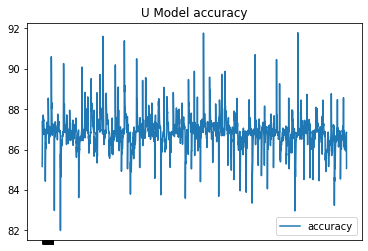

Epoch [101/1000], Step [0/27], Loss: 0.075307, Accuracy:85.06978352864583
Epoch [102/1000], Step [0/27], Loss: 0.075559, Accuracy:84.4696044921875
Epoch [103/1000], Step [0/27], Loss: 0.057007, Accuracy:87.68819173177083
Epoch [104/1000], Step [0/27], Loss: 0.054838, Accuracy:87.52237955729167
Epoch [105/1000], Step [0/27], Loss: 0.077606, Accuracy:84.82716878255208
Epoch [106/1000], Step [0/27], Loss: 0.060719, Accuracy:87.92063395182292
Epoch [107/1000], Step [0/27], Loss: 0.086202, Accuracy:82.55716959635417
Epoch [108/1000], Step [0/27], Loss: 0.065890, Accuracy:87.109375
Epoch [109/1000], Step [0/27], Loss: 0.072687, Accuracy:85.4217529296875
Epoch [110/1000], Step [0/27], Loss: 0.081455, Accuracy:83.44217936197917
Epoch [111/1000], Step [0/27], Loss: 0.068145, Accuracy:86.72231038411458
Epoch [112/1000], Step [0/27], Loss: 0.078223, Accuracy:84.55454508463542
Epoch [113/1000], Step [0/27], Loss: 0.048134, Accuracy:89.874267578125
Epoch [114/1000], Step [0/27], Loss: 0.078813, Acc

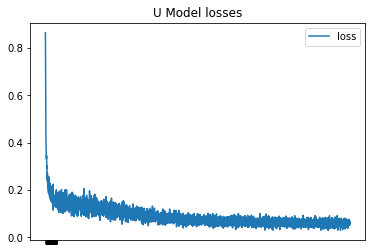

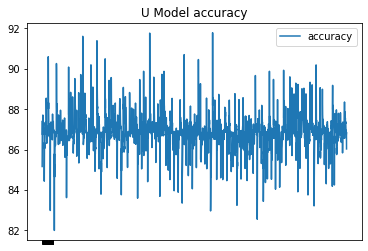

Epoch [151/1000], Step [0/27], Loss: 0.065899, Accuracy:86.03363037109375
Epoch [152/1000], Step [0/27], Loss: 0.063956, Accuracy:85.68522135416667
Epoch [153/1000], Step [0/27], Loss: 0.060172, Accuracy:87.33062744140625
Epoch [154/1000], Step [0/27], Loss: 0.055457, Accuracy:87.7197265625
Epoch [155/1000], Step [0/27], Loss: 0.070460, Accuracy:84.33125813802083
Epoch [156/1000], Step [0/27], Loss: 0.055329, Accuracy:87.08597819010417
Epoch [157/1000], Step [0/27], Loss: 0.054124, Accuracy:87.62359619140625
Epoch [158/1000], Step [0/27], Loss: 0.065405, Accuracy:85.26560465494792
Epoch [159/1000], Step [0/27], Loss: 0.067199, Accuracy:85.07181803385417
Epoch [160/1000], Step [0/27], Loss: 0.034413, Accuracy:91.1285400390625
Epoch [161/1000], Step [0/27], Loss: 0.057063, Accuracy:86.58498128255208
Epoch [162/1000], Step [0/27], Loss: 0.047065, Accuracy:89.21407063802083
Epoch [163/1000], Step [0/27], Loss: 0.052233, Accuracy:87.74363199869792
Epoch [164/1000], Step [0/27], Loss: 0.0512

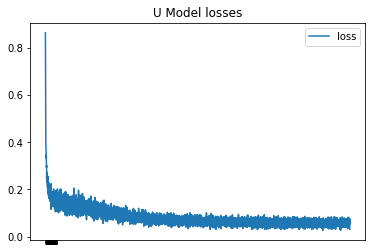

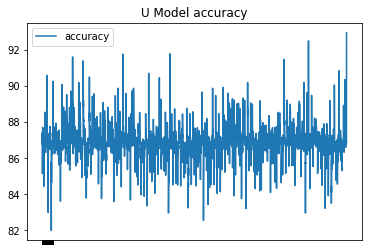

Epoch [201/1000], Step [0/27], Loss: 0.030733, Accuracy:92.94281005859375
Epoch [202/1000], Step [0/27], Loss: 0.052099, Accuracy:87.47914632161458
Epoch [203/1000], Step [0/27], Loss: 0.051630, Accuracy:87.46846516927083
Epoch [204/1000], Step [0/27], Loss: 0.065614, Accuracy:84.91363525390625
Epoch [205/1000], Step [0/27], Loss: 0.046848, Accuracy:89.15812174479167
Epoch [206/1000], Step [0/27], Loss: 0.041450, Accuracy:89.2852783203125
Epoch [207/1000], Step [0/27], Loss: 0.054437, Accuracy:86.54836018880208
Epoch [208/1000], Step [0/27], Loss: 0.065526, Accuracy:84.90956624348958
Epoch [209/1000], Step [0/27], Loss: 0.057877, Accuracy:86.67704264322917
Epoch [210/1000], Step [0/27], Loss: 0.054200, Accuracy:88.14544677734375
Epoch [211/1000], Step [0/27], Loss: 0.042005, Accuracy:87.84637451171875
Epoch [212/1000], Step [0/27], Loss: 0.055955, Accuracy:86.98781331380208
Epoch [213/1000], Step [0/27], Loss: 0.059730, Accuracy:86.88557942708333
Epoch [214/1000], Step [0/27], Loss: 0.

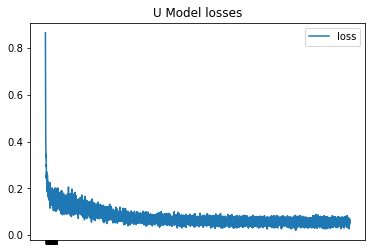

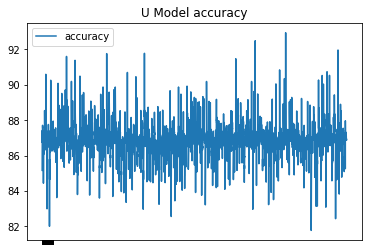

Epoch [251/1000], Step [0/27], Loss: 0.055975, Accuracy:86.88710530598958
Epoch [252/1000], Step [0/27], Loss: 0.053666, Accuracy:86.90694173177083
Epoch [253/1000], Step [0/27], Loss: 0.067105, Accuracy:84.45332845052083
Epoch [254/1000], Step [0/27], Loss: 0.068032, Accuracy:83.97674560546875
Epoch [255/1000], Step [0/27], Loss: 0.063715, Accuracy:85.18880208333333
Epoch [256/1000], Step [0/27], Loss: 0.038868, Accuracy:90.56396484375
Epoch [257/1000], Step [0/27], Loss: 0.056713, Accuracy:86.99137369791667
Epoch [258/1000], Step [0/27], Loss: 0.063942, Accuracy:84.76053873697917
Epoch [259/1000], Step [0/27], Loss: 0.062795, Accuracy:85.05808512369792
Epoch [260/1000], Step [0/27], Loss: 0.069020, Accuracy:83.59934488932292
Epoch [261/1000], Step [0/27], Loss: 0.061293, Accuracy:85.9466552734375
Epoch [262/1000], Step [0/27], Loss: 0.027262, Accuracy:92.85227457682292
Epoch [263/1000], Step [0/27], Loss: 0.049352, Accuracy:87.80619303385417
Epoch [264/1000], Step [0/27], Loss: 0.059

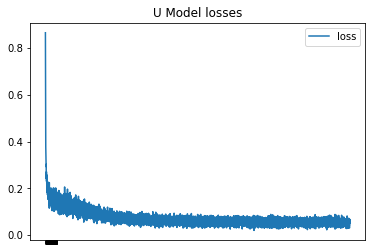

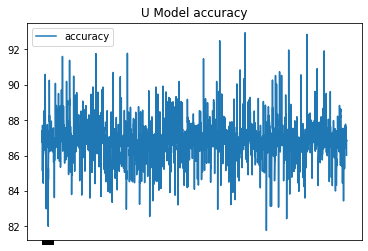

Epoch [301/1000], Step [0/27], Loss: 0.060558, Accuracy:86.01481119791667
Epoch [302/1000], Step [0/27], Loss: 0.058427, Accuracy:86.64805094401042
Epoch [303/1000], Step [0/27], Loss: 0.050866, Accuracy:87.59969075520833
Epoch [304/1000], Step [0/27], Loss: 0.049614, Accuracy:88.46944173177083
Epoch [305/1000], Step [0/27], Loss: 0.063323, Accuracy:85.565185546875
Epoch [306/1000], Step [0/27], Loss: 0.056983, Accuracy:87.06105550130208
Epoch [307/1000], Step [0/27], Loss: 0.053215, Accuracy:87.17091878255208
Epoch [308/1000], Step [0/27], Loss: 0.064523, Accuracy:84.71221923828125
Epoch [309/1000], Step [0/27], Loss: 0.055197, Accuracy:86.95322672526042
Epoch [310/1000], Step [0/27], Loss: 0.048988, Accuracy:87.75736490885417
Epoch [311/1000], Step [0/27], Loss: 0.039625, Accuracy:88.95161946614583
Epoch [312/1000], Step [0/27], Loss: 0.046971, Accuracy:88.89312744140625
Epoch [313/1000], Step [0/27], Loss: 0.062189, Accuracy:85.53873697916667
Epoch [314/1000], Step [0/27], Loss: 0.0

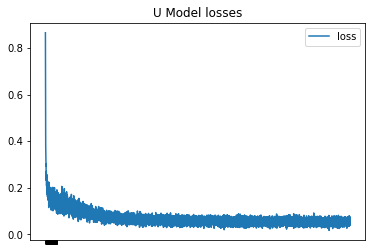

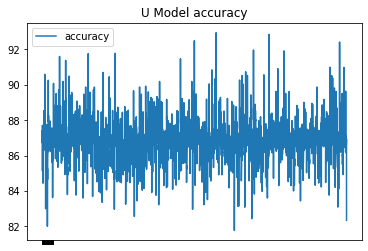

Epoch [351/1000], Step [0/27], Loss: 0.075028, Accuracy:82.33998616536458
Epoch [352/1000], Step [0/27], Loss: 0.068909, Accuracy:83.79058837890625
Epoch [353/1000], Step [0/27], Loss: 0.051765, Accuracy:87.95318603515625
Epoch [354/1000], Step [0/27], Loss: 0.037363, Accuracy:90.10009765625
Epoch [355/1000], Step [0/27], Loss: 0.062081, Accuracy:85.003662109375
Epoch [356/1000], Step [0/27], Loss: 0.045450, Accuracy:88.81785074869792
Epoch [357/1000], Step [0/27], Loss: 0.070558, Accuracy:84.25394694010417
Epoch [358/1000], Step [0/27], Loss: 0.046983, Accuracy:88.323974609375
Epoch [359/1000], Step [0/27], Loss: 0.066311, Accuracy:84.22088623046875
Epoch [360/1000], Step [0/27], Loss: 0.057414, Accuracy:86.67805989583333
Epoch [361/1000], Step [0/27], Loss: 0.045982, Accuracy:89.64691162109375
Epoch [362/1000], Step [0/27], Loss: 0.078461, Accuracy:82.25148518880208
Epoch [363/1000], Step [0/27], Loss: 0.050391, Accuracy:87.13277180989583
Epoch [364/1000], Step [0/27], Loss: 0.048247

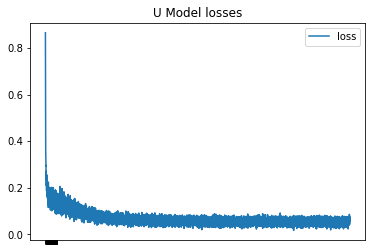

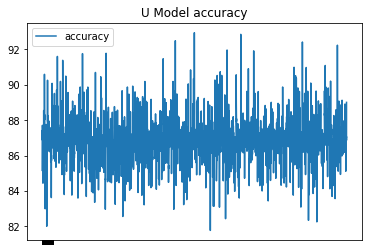

Epoch [401/1000], Step [0/27], Loss: 0.046852, Accuracy:89.00705973307292
Epoch [402/1000], Step [0/27], Loss: 0.075759, Accuracy:86.15010579427083
Epoch [403/1000], Step [0/27], Loss: 0.055577, Accuracy:87.40692138671875
Epoch [404/1000], Step [0/27], Loss: 0.068641, Accuracy:85.55959065755208
Epoch [405/1000], Step [0/27], Loss: 0.070026, Accuracy:85.12522379557292
Epoch [406/1000], Step [0/27], Loss: 0.057735, Accuracy:86.43595377604167
Epoch [407/1000], Step [0/27], Loss: 0.064592, Accuracy:86.10636393229167
Epoch [408/1000], Step [0/27], Loss: 0.077394, Accuracy:83.89841715494792
Epoch [409/1000], Step [0/27], Loss: 0.054897, Accuracy:86.75130208333333
Epoch [410/1000], Step [0/27], Loss: 0.046251, Accuracy:88.00608317057292
Epoch [411/1000], Step [0/27], Loss: 0.037632, Accuracy:90.92814127604167
Epoch [412/1000], Step [0/27], Loss: 0.065431, Accuracy:84.94110107421875
Epoch [413/1000], Step [0/27], Loss: 0.050979, Accuracy:87.61850992838542
Epoch [414/1000], Step [0/27], Loss: 0

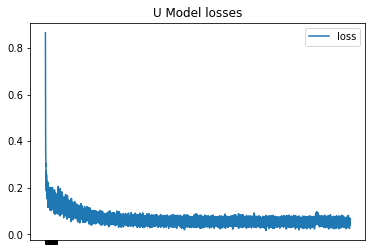

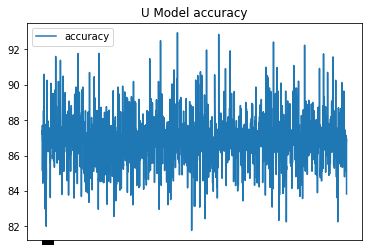

Epoch [451/1000], Step [0/27], Loss: 0.067424, Accuracy:83.82924397786458
Epoch [452/1000], Step [0/27], Loss: 0.041238, Accuracy:87.39166259765625
Epoch [453/1000], Step [0/27], Loss: 0.060544, Accuracy:84.85107421875
Epoch [454/1000], Step [0/27], Loss: 0.063504, Accuracy:84.62270100911458
Epoch [455/1000], Step [0/27], Loss: 0.062173, Accuracy:85.20863850911458
Epoch [456/1000], Step [0/27], Loss: 0.059030, Accuracy:85.9222412109375
Epoch [457/1000], Step [0/27], Loss: 0.049058, Accuracy:88.0706787109375
Epoch [458/1000], Step [0/27], Loss: 0.045129, Accuracy:88.7359619140625
Epoch [459/1000], Step [0/27], Loss: 0.058965, Accuracy:86.38661702473958
Epoch [460/1000], Step [0/27], Loss: 0.071760, Accuracy:83.55153401692708
Epoch [461/1000], Step [0/27], Loss: 0.043638, Accuracy:89.09657796223958
Epoch [462/1000], Step [0/27], Loss: 0.065490, Accuracy:84.2559814453125
Epoch [463/1000], Step [0/27], Loss: 0.059486, Accuracy:85.68471272786458
Epoch [464/1000], Step [0/27], Loss: 0.044835

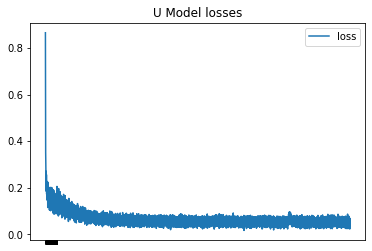

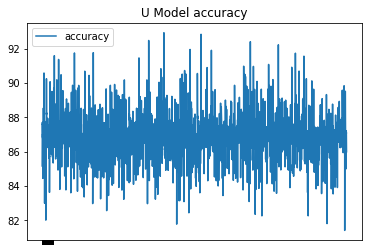

Epoch [501/1000], Step [0/27], Loss: 0.060645, Accuracy:85.99497477213542
Epoch [502/1000], Step [0/27], Loss: 0.040032, Accuracy:89.62656656901042
Epoch [503/1000], Step [0/27], Loss: 0.039521, Accuracy:91.08123779296875
Epoch [504/1000], Step [0/27], Loss: 0.050891, Accuracy:87.81229654947917
Epoch [505/1000], Step [0/27], Loss: 0.053492, Accuracy:87.60426839192708
Epoch [506/1000], Step [0/27], Loss: 0.079276, Accuracy:81.66656494140625
Epoch [507/1000], Step [0/27], Loss: 0.046926, Accuracy:88.18868001302083
Epoch [508/1000], Step [0/27], Loss: 0.057816, Accuracy:85.6109619140625
Epoch [509/1000], Step [0/27], Loss: 0.034260, Accuracy:89.50042724609375
Epoch [510/1000], Step [0/27], Loss: 0.044522, Accuracy:89.11946614583333
Epoch [511/1000], Step [0/27], Loss: 0.036449, Accuracy:90.66162109375
Epoch [512/1000], Step [0/27], Loss: 0.067633, Accuracy:84.45027669270833
Epoch [513/1000], Step [0/27], Loss: 0.031870, Accuracy:91.02528889973958
Epoch [514/1000], Step [0/27], Loss: 0.058

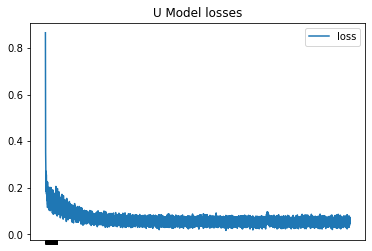

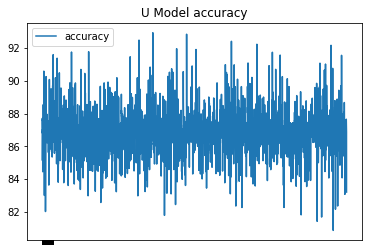

Epoch [551/1000], Step [0/27], Loss: 0.072664, Accuracy:83.1939697265625
Epoch [552/1000], Step [0/27], Loss: 0.034032, Accuracy:92.20123291015625
Epoch [553/1000], Step [0/27], Loss: 0.050268, Accuracy:88.5162353515625
Epoch [554/1000], Step [0/27], Loss: 0.040924, Accuracy:89.45871988932292
Epoch [555/1000], Step [0/27], Loss: 0.054119, Accuracy:86.73197428385417
Epoch [556/1000], Step [0/27], Loss: 0.046149, Accuracy:89.0533447265625
Epoch [557/1000], Step [0/27], Loss: 0.041926, Accuracy:88.35856119791667
Epoch [558/1000], Step [0/27], Loss: 0.052403, Accuracy:87.38861083984375
Epoch [559/1000], Step [0/27], Loss: 0.046027, Accuracy:87.73040771484375
Epoch [560/1000], Step [0/27], Loss: 0.057932, Accuracy:86.10178629557292
Epoch [561/1000], Step [0/27], Loss: 0.032299, Accuracy:90.63720703125
Epoch [562/1000], Step [0/27], Loss: 0.029121, Accuracy:93.02927652994792
Epoch [563/1000], Step [0/27], Loss: 0.042674, Accuracy:87.50457763671875
Epoch [564/1000], Step [0/27], Loss: 0.06701

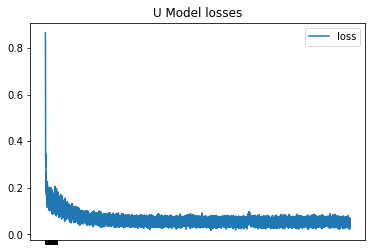

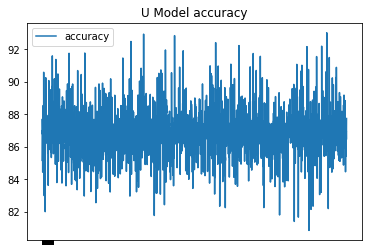

Epoch [601/1000], Step [0/27], Loss: 0.048563, Accuracy:87.74464925130208
Epoch [602/1000], Step [0/27], Loss: 0.058259, Accuracy:86.77266438802083
Epoch [603/1000], Step [0/27], Loss: 0.058655, Accuracy:84.62727864583333
Epoch [604/1000], Step [0/27], Loss: 0.054248, Accuracy:87.93894449869792
Epoch [605/1000], Step [0/27], Loss: 0.060240, Accuracy:85.95326741536458
Epoch [606/1000], Step [0/27], Loss: 0.066600, Accuracy:84.86989339192708
Epoch [607/1000], Step [0/27], Loss: 0.049240, Accuracy:86.4654541015625
Epoch [608/1000], Step [0/27], Loss: 0.081634, Accuracy:81.89493815104167
Epoch [609/1000], Step [0/27], Loss: 0.055972, Accuracy:86.43341064453125
Epoch [610/1000], Step [0/27], Loss: 0.053585, Accuracy:87.08902994791667
Epoch [611/1000], Step [0/27], Loss: 0.041660, Accuracy:88.04423014322917
Epoch [612/1000], Step [0/27], Loss: 0.042714, Accuracy:89.1143798828125
Epoch [613/1000], Step [0/27], Loss: 0.043548, Accuracy:87.96946207682292
Epoch [614/1000], Step [0/27], Loss: 0.0

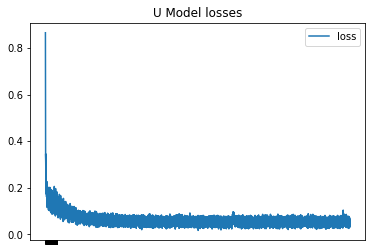

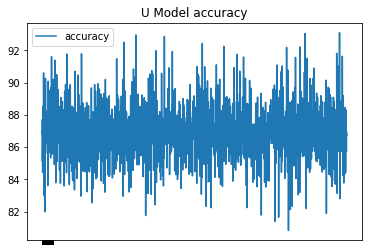

Epoch [651/1000], Step [0/27], Loss: 0.059918, Accuracy:85.77016194661458
Epoch [652/1000], Step [0/27], Loss: 0.067238, Accuracy:84.44671630859375
Epoch [653/1000], Step [0/27], Loss: 0.049974, Accuracy:87.61189778645833
Epoch [654/1000], Step [0/27], Loss: 0.048754, Accuracy:88.92822265625
Epoch [655/1000], Step [0/27], Loss: 0.032103, Accuracy:91.57257080078125
Epoch [656/1000], Step [0/27], Loss: 0.043399, Accuracy:89.06504313151042
Epoch [657/1000], Step [0/27], Loss: 0.065632, Accuracy:85.36529541015625
Epoch [658/1000], Step [0/27], Loss: 0.073014, Accuracy:82.90557861328125
Epoch [659/1000], Step [0/27], Loss: 0.053868, Accuracy:86.77113850911458
Epoch [660/1000], Step [0/27], Loss: 0.057393, Accuracy:87.45371500651042
Epoch [661/1000], Step [0/27], Loss: 0.036642, Accuracy:90.36763509114583
Epoch [662/1000], Step [0/27], Loss: 0.061113, Accuracy:85.79915364583333
Epoch [663/1000], Step [0/27], Loss: 0.062325, Accuracy:85.72591145833333
Epoch [664/1000], Step [0/27], Loss: 0.05

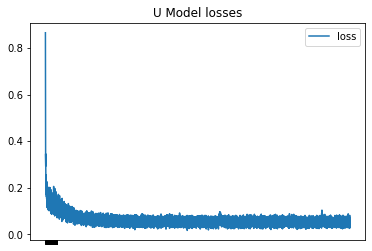

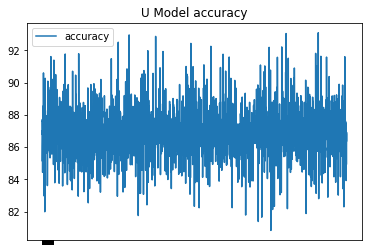

Epoch [701/1000], Step [0/27], Loss: 0.063547, Accuracy:84.97060139973958
Epoch [702/1000], Step [0/27], Loss: 0.064064, Accuracy:84.893798828125
Epoch [703/1000], Step [0/27], Loss: 0.034427, Accuracy:91.03139241536458
Epoch [704/1000], Step [0/27], Loss: 0.040676, Accuracy:88.73545328776042
Epoch [705/1000], Step [0/27], Loss: 0.075180, Accuracy:81.9427490234375
Epoch [706/1000], Step [0/27], Loss: 0.047205, Accuracy:86.27522786458333
Epoch [707/1000], Step [0/27], Loss: 0.062090, Accuracy:84.87192789713542
Epoch [708/1000], Step [0/27], Loss: 0.046330, Accuracy:87.86875406901042
Epoch [709/1000], Step [0/27], Loss: 0.062489, Accuracy:85.41615804036458
Epoch [710/1000], Step [0/27], Loss: 0.040468, Accuracy:88.95161946614583
Epoch [711/1000], Step [0/27], Loss: 0.048274, Accuracy:87.06156412760417
Epoch [712/1000], Step [0/27], Loss: 0.055792, Accuracy:86.3525390625
Epoch [713/1000], Step [0/27], Loss: 0.051847, Accuracy:86.59617106119792
Epoch [714/1000], Step [0/27], Loss: 0.044245

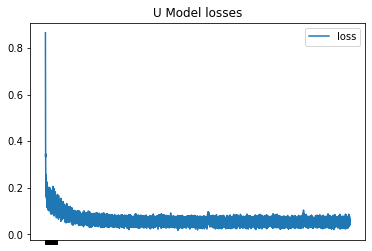

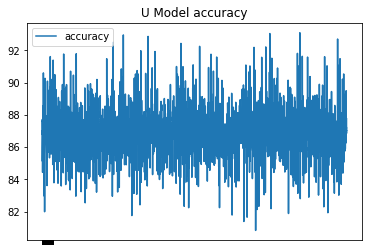

Epoch [751/1000], Step [0/27], Loss: 0.050508, Accuracy:87.75838216145833
Epoch [752/1000], Step [0/27], Loss: 0.052798, Accuracy:87.35198974609375
Epoch [753/1000], Step [0/27], Loss: 0.029320, Accuracy:90.50750732421875
Epoch [754/1000], Step [0/27], Loss: 0.071724, Accuracy:83.88315836588542
Epoch [755/1000], Step [0/27], Loss: 0.055202, Accuracy:86.64296468098958
Epoch [756/1000], Step [0/27], Loss: 0.073646, Accuracy:82.05668131510417
Epoch [757/1000], Step [0/27], Loss: 0.044953, Accuracy:88.62711588541667
Epoch [758/1000], Step [0/27], Loss: 0.028182, Accuracy:92.54506429036458
Epoch [759/1000], Step [0/27], Loss: 0.045744, Accuracy:88.21004231770833
Epoch [760/1000], Step [0/27], Loss: 0.044437, Accuracy:88.8763427734375
Epoch [761/1000], Step [0/27], Loss: 0.066579, Accuracy:83.8134765625
Epoch [762/1000], Step [0/27], Loss: 0.059455, Accuracy:85.16642252604167
Epoch [763/1000], Step [0/27], Loss: 0.039317, Accuracy:90.42867024739583
Epoch [764/1000], Step [0/27], Loss: 0.0551

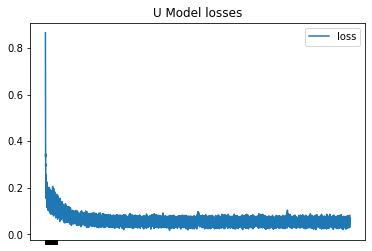

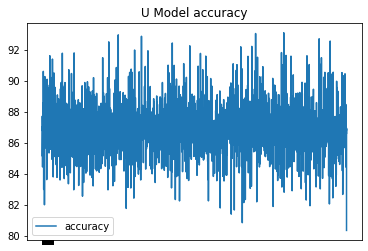

Epoch [801/1000], Step [0/27], Loss: 0.081642, Accuracy:80.352783203125
Epoch [802/1000], Step [0/27], Loss: 0.053816, Accuracy:86.62211100260417
Epoch [803/1000], Step [0/27], Loss: 0.054989, Accuracy:85.71014404296875
Epoch [804/1000], Step [0/27], Loss: 0.046818, Accuracy:89.15252685546875
Epoch [805/1000], Step [0/27], Loss: 0.049821, Accuracy:87.07326253255208
Epoch [806/1000], Step [0/27], Loss: 0.052034, Accuracy:87.7532958984375
Epoch [807/1000], Step [0/27], Loss: 0.050751, Accuracy:87.1612548828125
Epoch [808/1000], Step [0/27], Loss: 0.061809, Accuracy:85.60028076171875
Epoch [809/1000], Step [0/27], Loss: 0.069935, Accuracy:82.7667236328125
Epoch [810/1000], Step [0/27], Loss: 0.045243, Accuracy:88.87837727864583
Epoch [811/1000], Step [0/27], Loss: 0.059603, Accuracy:85.02705891927083
Epoch [812/1000], Step [0/27], Loss: 0.039020, Accuracy:88.59456380208333
Epoch [813/1000], Step [0/27], Loss: 0.070560, Accuracy:83.09173583984375
Epoch [814/1000], Step [0/27], Loss: 0.0606

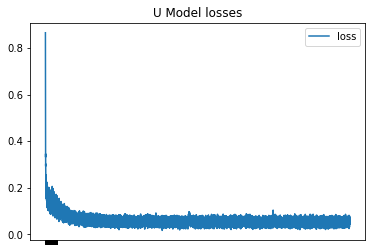

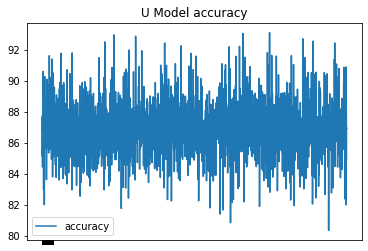

Epoch [851/1000], Step [0/27], Loss: 0.063522, Accuracy:84.89786783854167
Epoch [852/1000], Step [0/27], Loss: 0.054355, Accuracy:86.61295572916667
Epoch [853/1000], Step [0/27], Loss: 0.063214, Accuracy:84.43857828776042
Epoch [854/1000], Step [0/27], Loss: 0.051380, Accuracy:87.51424153645833
Epoch [855/1000], Step [0/27], Loss: 0.050429, Accuracy:87.054443359375
Epoch [856/1000], Step [0/27], Loss: 0.052724, Accuracy:86.16689046223958
Epoch [857/1000], Step [0/27], Loss: 0.051853, Accuracy:87.10428873697917
Epoch [858/1000], Step [0/27], Loss: 0.056474, Accuracy:85.78643798828125
Epoch [859/1000], Step [0/27], Loss: 0.066337, Accuracy:85.68929036458333
Epoch [860/1000], Step [0/27], Loss: 0.044934, Accuracy:87.79042561848958
Epoch [861/1000], Step [0/27], Loss: 0.059390, Accuracy:86.06007893880208
Epoch [862/1000], Step [0/27], Loss: 0.058272, Accuracy:84.99552408854167
Epoch [863/1000], Step [0/27], Loss: 0.042299, Accuracy:88.32855224609375
Epoch [864/1000], Step [0/27], Loss: 0.0

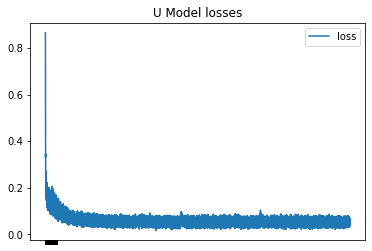

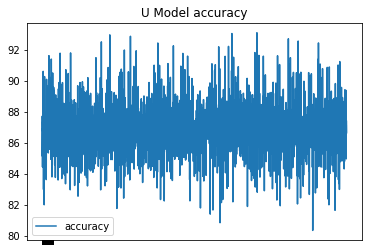

Epoch [901/1000], Step [0/27], Loss: 0.054326, Accuracy:86.63736979166667
Epoch [902/1000], Step [0/27], Loss: 0.050002, Accuracy:87.74515787760417
Epoch [903/1000], Step [0/27], Loss: 0.065723, Accuracy:85.14811197916667
Epoch [904/1000], Step [0/27], Loss: 0.056187, Accuracy:86.43341064453125
Epoch [905/1000], Step [0/27], Loss: 0.057933, Accuracy:85.516357421875
Epoch [906/1000], Step [0/27], Loss: 0.042226, Accuracy:89.19932047526042
Epoch [907/1000], Step [0/27], Loss: 0.071996, Accuracy:83.69242350260417
Epoch [908/1000], Step [0/27], Loss: 0.046221, Accuracy:88.31787109375
Epoch [909/1000], Step [0/27], Loss: 0.067079, Accuracy:83.90604654947917
Epoch [910/1000], Step [0/27], Loss: 0.041058, Accuracy:89.69777425130208
Epoch [911/1000], Step [0/27], Loss: 0.072489, Accuracy:83.53322347005208
Epoch [912/1000], Step [0/27], Loss: 0.052980, Accuracy:84.95127360026042
Epoch [913/1000], Step [0/27], Loss: 0.051787, Accuracy:86.46443684895833
Epoch [914/1000], Step [0/27], Loss: 0.0390

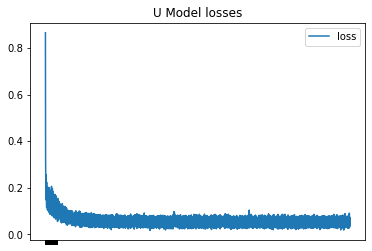

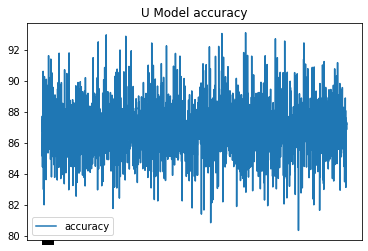

Epoch [951/1000], Step [0/27], Loss: 0.051430, Accuracy:87.25840250651042
Epoch [952/1000], Step [0/27], Loss: 0.065337, Accuracy:84.33634440104167
Epoch [953/1000], Step [0/27], Loss: 0.067056, Accuracy:84.00675455729167
Epoch [954/1000], Step [0/27], Loss: 0.071554, Accuracy:83.67411295572917
Epoch [955/1000], Step [0/27], Loss: 0.064145, Accuracy:84.539794921875
Epoch [956/1000], Step [0/27], Loss: 0.040841, Accuracy:89.81424967447917
Epoch [957/1000], Step [0/27], Loss: 0.055868, Accuracy:85.37546793619792
Epoch [958/1000], Step [0/27], Loss: 0.035574, Accuracy:90.87066650390625
Epoch [959/1000], Step [0/27], Loss: 0.061791, Accuracy:85.19032796223958
Epoch [960/1000], Step [0/27], Loss: 0.040339, Accuracy:90.19826253255208
Epoch [961/1000], Step [0/27], Loss: 0.060943, Accuracy:86.08754475911458
Epoch [962/1000], Step [0/27], Loss: 0.054627, Accuracy:85.80169677734375
Epoch [963/1000], Step [0/27], Loss: 0.061482, Accuracy:84.74375406901042
Epoch [964/1000], Step [0/27], Loss: 0.0

In [12]:
# The training loop
epochs = 1000
total_steps = len(train_loader)
#print(f"{epochs} epochs, {total_steps} total_steps per epoch")

losses = []
acc = []

start = time.time()

for epoch in range(epochs):
    total_train = 0
    correct_train = 0
    for i, (images, masks) in enumerate(train_loader):
        #print(masks.shape)

        images = images.to(device)        
        masks = masks.to(device)

        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)        
        losses.append(loss)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += images.nelement()       
        correct_train += predicted.eq(torch.squeeze(images.data)).sum().item()        
        train_accuracy = 100 * correct_train / total_train
        acc.append(train_accuracy)
        
        if(epoch%50 ==0 and i==0):
            ax = plt.axes()
            plt.title("U Model losses")
            plt.plot(losses, label="loss")
            plt.xticks(np.arange(1, epoch, step = 1.0))
            ax.xaxis.set_major_formatter(plt.NullFormatter())
            plt.legend()
            plt.show()
                    
        if(epoch%50 ==0 and i==0):
            ax = plt.axes()
            plt.title("U Model accuracy")
            plt.plot(acc, label="accuracy")
            plt.xticks(np.arange(1, epoch, step = 1.0))
            ax.xaxis.set_major_formatter(plt.NullFormatter())
            plt.legend()
            plt.show()
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}, Accuracy:{train_accuracy}")
    

end = time.time()
training_time = end - start
print('training time: ', training_time)

In [ ]:
from scipy.ndimage import uniform_filter1d, convolve1d, convolve,gaussian_filter

0
loss: tensor(0.1213, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 88.5101318359375
test time for 0  :  0.14261984825134277


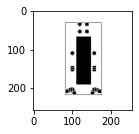

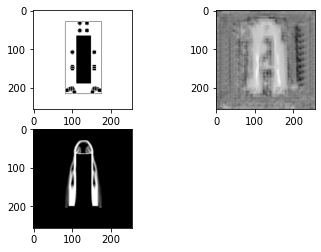

1
loss: tensor(0.1297, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 88.33770751953125
test time for 1  :  0.12961602210998535


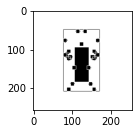

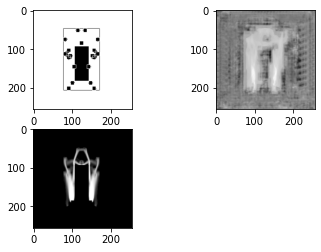

2
loss: tensor(0.2063, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 86.72281901041667
test time for 2  :  0.23839569091796875


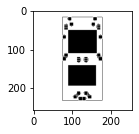

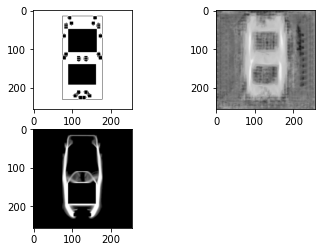

3
loss: tensor(0.3007, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 85.46943664550781
test time for 3  :  0.1386277675628662


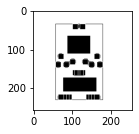

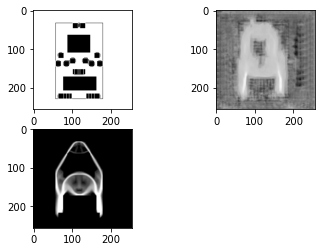

4
loss: tensor(0.1385, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 85.53680419921875
test time for 4  :  0.13763165473937988


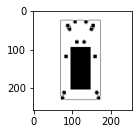

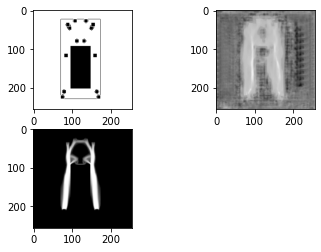

5
loss: tensor(0.1297, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 85.92147827148438
test time for 5  :  0.1356668472290039


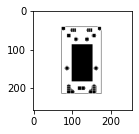

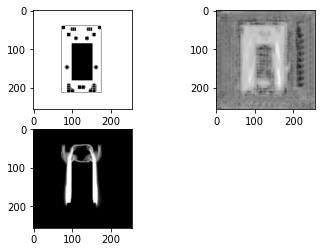

6
loss: tensor(0.5667, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 84.98753138950893
test time for 6  :  0.12566280364990234


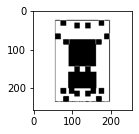

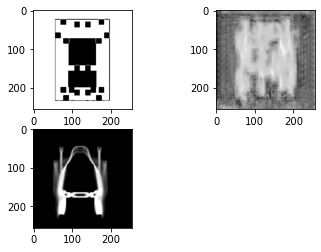

7
loss: tensor(0.1606, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 85.19172668457031
test time for 7  :  0.13164758682250977


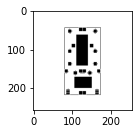

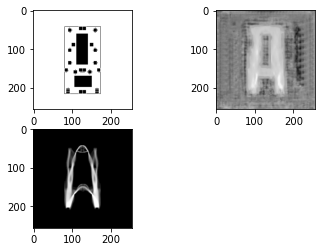

8
loss: tensor(0.2831, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 84.72900390625
test time for 8  :  0.12865495681762695


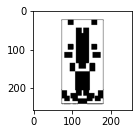

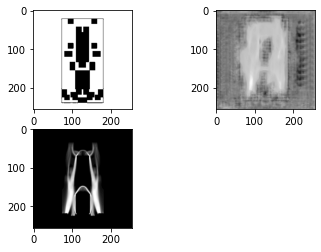

In [14]:
total_test = 0
correct_test = 0

for i, (images, masks) in enumerate(test_loader):
    start = time.time()
    print(i)
   
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    
    masks = masks.to(device)
    images = images.to(device)
    output = model(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
    loss = criterion(output, images)
   
    print("loss:", loss)
    
     # accuracy
    _, predicted = torch.max(output.data, 1)
    total_test += images.nelement()
    correct_test +=predicted.eq(torch.squeeze(images.data)).sum().item()
    test_accuracy = 100 * correct_test / total_test
    print("test accuracy:", test_accuracy)
    
    end = time.time()
    test_time = end - start
    print('test time for',i, ' : ', test_time)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    plt.show()
